### Kernel Density Estimation

In [2]:
from Utilities.utils import read_data

In [3]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, _ = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:21: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [4]:
T90, T90_err, fluence, fluence_err = zip(*[(float(a), float(b), float(c), float(d)) for a, b, c, d in zip(raw[6], raw[7], raw[9], raw[10]) 
                                           if a != '-999' and b != '-999' and float(b)!=0 
                                           and c != '-999' and float(c) != 0
                                           and d != '-999' and float(d) != 0])

In [5]:
import numpy as np

In [6]:
T90 = np.log10(np.array(T90))

In [7]:
import matplotlib.pyplot as plt
from Utilities import plot_settings

Text(0, 0.5, 'Density')

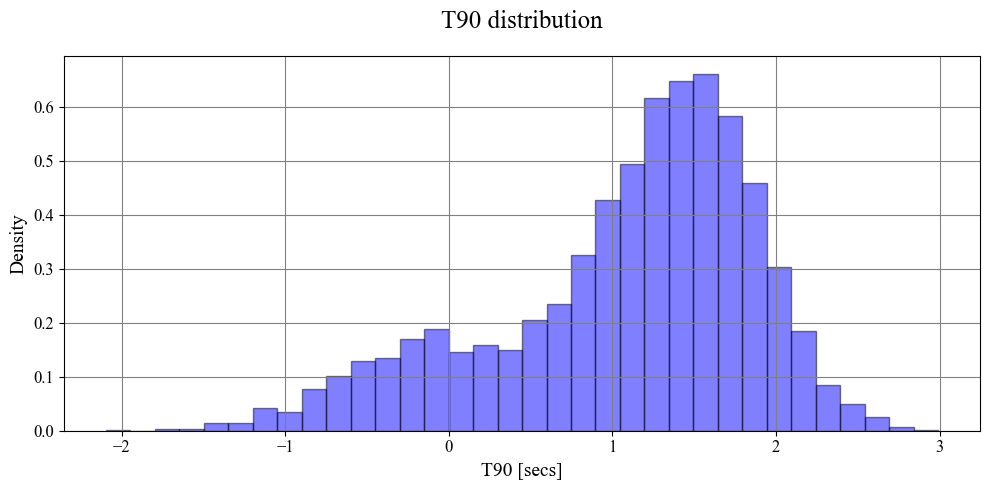

In [8]:
T90c, T90b, _ = plt.hist(T90, bins='scott', density=True, 
                         histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('T90 distribution')
plt.xlabel('T90 [secs]')
plt.ylabel('Density')

In [9]:
from sklearn.neighbors import KernelDensity

In [10]:
import numpy as np

In [11]:
X = T90.reshape((-1,1))

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)

In [20]:
bandwidths = np.linspace(0.0001,0.01,10)

In [21]:
from Utilities.utils import KDE_LOO, cross_validation_LOO

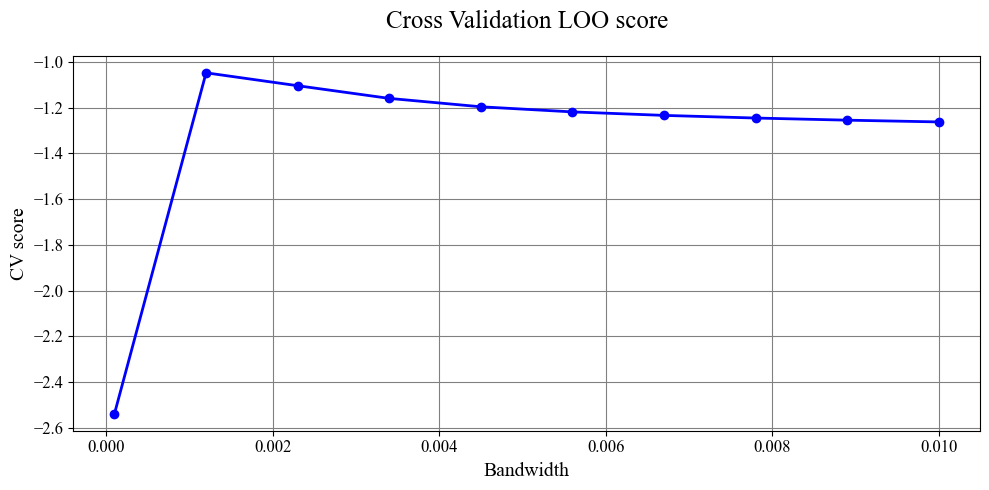

In [22]:
scores, best, best_bw = cross_validation_LOO(X_train, bandwidths, True)

In [33]:
xgrid = np.linspace(np.array(T90).min(), np.array(T90).max(),1000)

def kde_sklearn(data, bandwidth, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data)
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf), kde_skl

In [34]:
pdf, kde = kde_sklearn(X, 0.1)

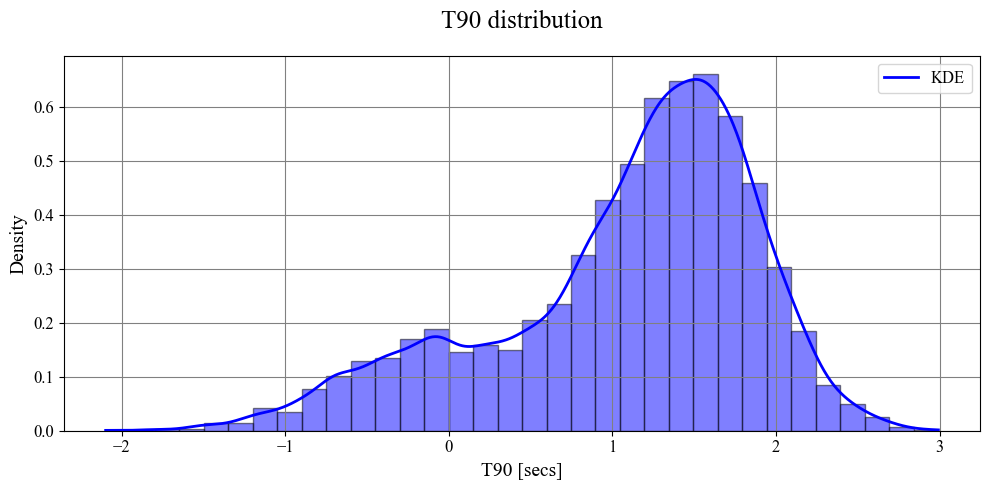

In [35]:
plt.plot(xgrid, pdf, color='blue', linewidth=2, label='KDE')
plt.hist(T90, bins='scott', density=True, histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('T90 distribution')
plt.xlabel('T90 [secs]')
plt.ylabel('Density')
plt.legend()

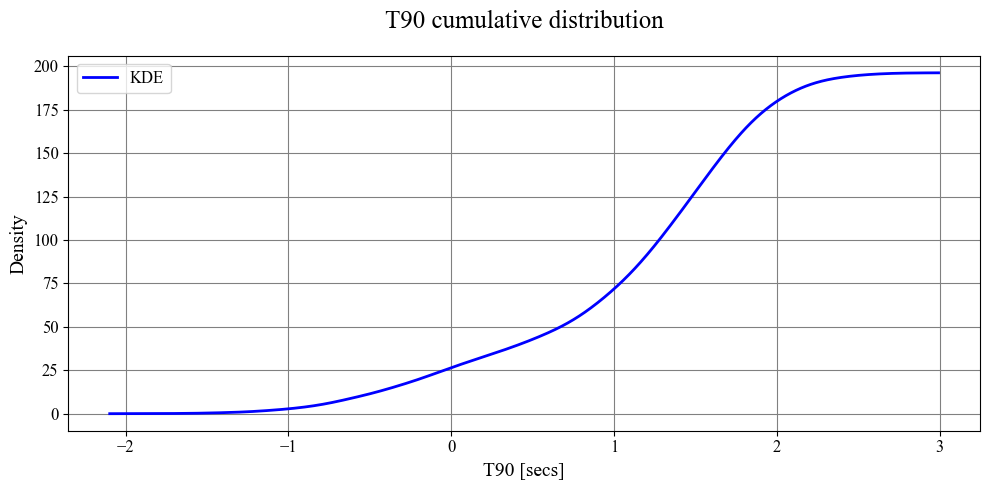

In [36]:
plt.plot(xgrid, np.cumsum(pdf), color='blue', linewidth=2, label='KDE')
plt.title('T90 cumulative distribution')
plt.xlabel('T90 [secs]')
plt.ylabel('Density')
plt.legend()

In [37]:
import scipy.stats

In [38]:
print('T90 Mean: ',T90.mean())
print('T90 Std: ', T90.std())
print('T90 mode:', scipy.stats.mode(T90).mode)
print('T90 max: ', T90.max())
print('T90 min: ', T90.min())

T90 Mean:  1.0762267823765699
T90 Std:  0.8122618384474906
T90 mode: -0.7166987712964504
T90 max:  2.993032170768195
T90 min:  -2.0969100130080562


## Gaussian Mixture

In [39]:
from sklearn.mixture import GaussianMixture

In [40]:
ns = np.arange(1,20,1)

In [44]:
aic = np.zeros_like(ns)
bic = np.zeros_like(ns)
for n in ns:
    GM = GaussianMixture(n_components=n)
    GM.fit(X_train)
    aic[n-min(ns)] = GM.aic(X_test)
    bic[n-min(ns)] = GM.bic(X_test)

Text(0.5, 1.0, 'Score vs components number')

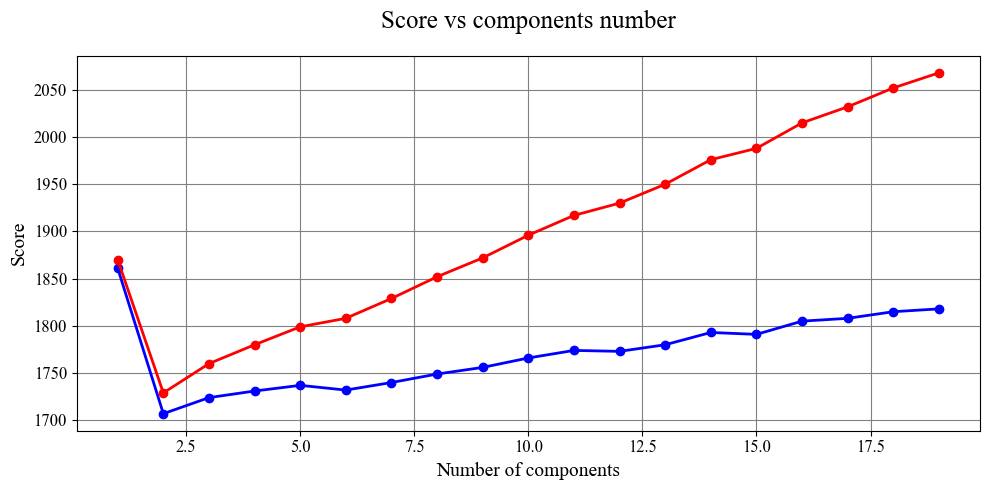

In [45]:
plt.plot(ns, aic, marker='o', color='blue', linewidth=2, label='AIC')
plt.plot(ns, bic, marker='o', color='red', linewidth=2, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Score vs components number')

In [47]:
GM = GaussianMixture(n_components=2)
GM.fit(X_train)

GaussianMixture(n_components=2)

In [69]:
x = np.linspace(X.min() - 0.5, X.max() + 0.5, 1000).reshape(-1, 1)

In [70]:
from scipy.stats import norm

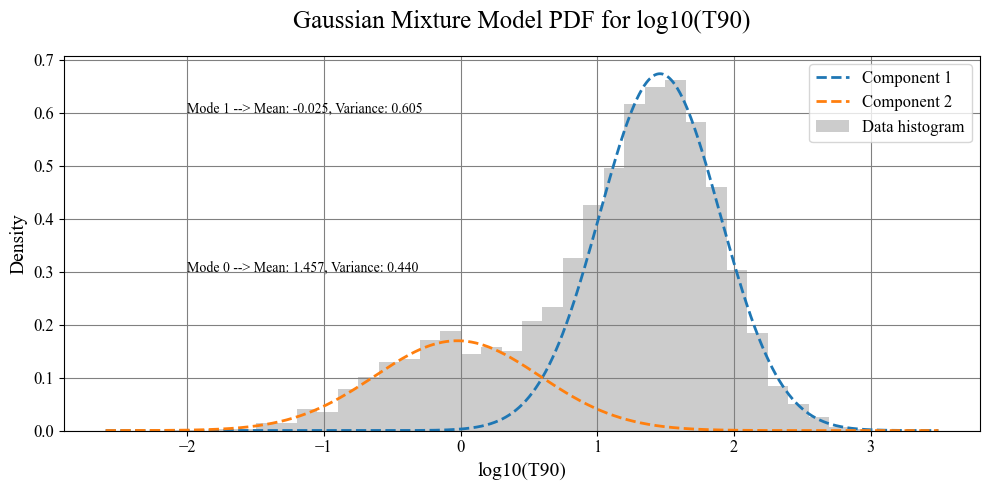

In [74]:
# Compute the weighted sum of PDFs from each Gaussian component
logprob = GM.score_samples(scaler.inverse_transform(x))
pdf = np.exp(logprob)

# Plot the overall PDF
#plt.plot(scaler.inverse_transform(x), pdf, label='Gaussian Mixture PDF', color='black')

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = scaler.inverse_transform(GM.means_)[i,0]
    # Standard deviation in original scale
    std_scaled = np.sqrt(GM.covariances_[i, 0, 0])
    std = std_scaled * scaler.scale_[0]  # undo StandardScaler
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '--', label=f'Component {i+1}')
    plt.text(-2, 0.3*(1+i), 
                f'Mode {i} --> Mean: {mean:.3f}, Variance: {std:.3f}')
# Add original data histogram for context
plt.hist(X, bins='scott', density=True, alpha=0.4, color='gray', label='Data histogram')

plt.xlabel('log10(T90)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(T90)')
plt.legend()

In [75]:
print(f'Short GRBs T90 centroid: {np.power(10,GM.means_[0, 0]):.3f} +/- {np.sqrt(GM.covariances_[0, 0, 0])*np.power(10,GM.means_[0, 0]):.3f} seconds')
print(f'Long  GRBs T90 centroid: {np.power(10,GM.means_[1, 0]):.3f} +/- {np.sqrt(GM.covariances_[1, 0, 0])*np.power(10,GM.means_[1, 0]):.3f} seconds')

Short GRBs T90 centroid: 2.940 +/- 1.594 seconds
Long  GRBs T90 centroid: 0.044 +/- 0.033 seconds


In [80]:
from scipy.optimize import brentq

In [85]:
x = scaler.inverse_transform(x)

In [86]:
pdf1 = lambda x: GM.weights_[0] * norm.pdf(x, GM.means_[0, 0], np.sqrt(GM.covariances_[0, 0, 0]))
pdf2 = lambda x: GM.weights_[1] * norm.pdf(x, GM.means_[1, 0], np.sqrt(GM.covariances_[1, 0, 0]))

In [87]:
diff12 = lambda x: pdf1(x) - pdf2(x)

In [88]:
threshold_12 = brentq(diff12, GM.means_[0, 0], GM.means_[1, 0])

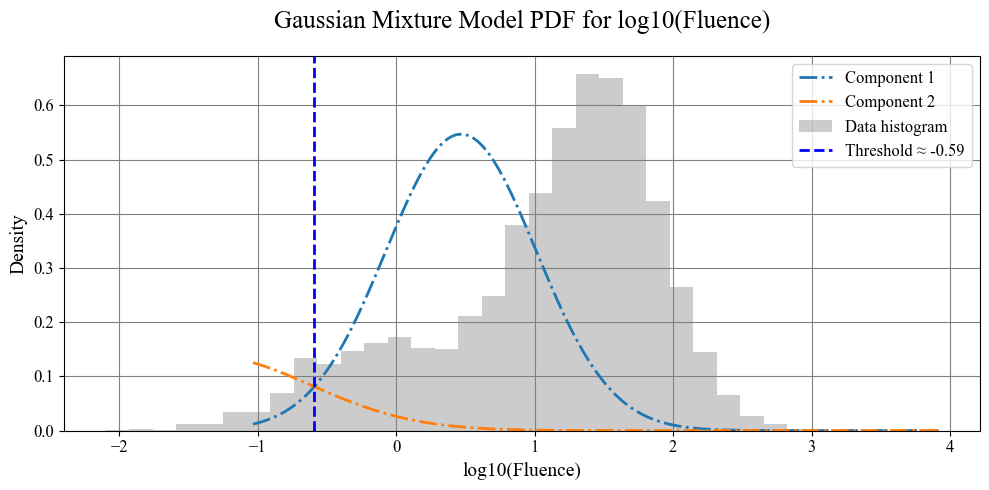

In [89]:
#plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '-.', label=f'Component {i+1}')

# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')
plt.axvline(threshold_12, color='blue', linestyle='--', label=f'Threshold ≈ {threshold_12:.2f}')
plt.xlabel('log10(Fluence)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(Fluence)')
plt.legend()

In [73]:
print(f'T90 treshold: {np.power(10, threshold_12):.3f} sec')

T90 treshold: 3.903 sec
